# Introduction to information theory (from a machine learning perspective)

This is an introduction to information theory from a machine learning perspective. We'll cover:
- expected value
- self-information
- entropy
- codes
- Shannon's source coding theorem
- cross entropy
- Kullback–Leibler (KL) divergence
- Jensen–Shannon (JS) divergence
- Wassterstein metric / earth mover's distance

**Expected Value**

An expected value is the average outcome we'd expect to see if we repeated an experiment an infinite number of times. If you play a game where you flip a fair coin (50% heads, and 50% tails) and you score 10 points whenever the coin lands on heads and -5 points when the coin lands on tails, the expected value is: $10 * 0.5 + -5 * 0.5 = 5 + -2.5 = 2.5$. This is effectively calculating a weighted average of outcome values.

More formally: let $X$ be a discrete random variable (can only pick from a discrete set of values) with distribution $p$ (where the distribution defines the probabilities for each of the discrete outcomes). Samples (e.g. individual coin flips) from $X$ are denoted by $x$. The expected value of $X$ is defined as:

$$\mathbb{E}_{X \sim p}[X]=\sum_xp(x)x$$

You may see this written in a few different notations, e.g.:

$$\mathbb{E}_{X \sim p}[X]=\mathbb{E}_{X}[X]=\mathbb{E}_{p}[X]=\mathbb{E}[X]$$

Let's calculate this in Python.

In [1]:
import numpy as np


def expectation(X, p):
    return np.sum([x * px for (x, px) in zip(X, p)])


X = [0, 1, 2, 3, 4]  # discrete values
p = [0.4, 0.3, 0.2, 0.05, 0.05]  # probability distribution

print(expectation(X, p))

1.05


`X[0] = 0`, `p[0] = 0.4` implies that when you sample the distribution, you will get a value of zero 40\% of the time. 30\% of the time you will get one (as `X[1] = 1`, `p[1] = 0.3`), 20% of of the time you will get two (as `X[2] = 2`, `p[2] = 0.2`), etc.

Now, let's sample from this distribution 100,000 times and see if we get a similar answer.

In [2]:
X = [0, 1, 2, 3, 4]
p = [0.4, 0.3, 0.2, 0.05, 0.05]

total = 0
N = 100_000

for _ in range(N):
    x = np.random.choice(X, p=p)
    total += x

print(total / N)

1.04918


Close enough!

We often want to apply functions to our input values. To calculate the expected value of our discrete random variable after a function has been applied can be found by applying the function to individual sampled values and taking the weighted average.

Formally: let $X$ be a random variable with distribution $p$ and let $f$ be a function. Then the expected value of the random variable $f(X)$ is given by:

$$\mathbb{E}_{f(X) \sim p}[f(X)]=\mathbb{E}_{X}[f(X)]=\sum_xp(x)f(x)$$

Using $f(x) = x^2$, let's calculate this:

In [2]:
X = [0, 1, 2, 3, 4]
p = [0.4, 0.3, 0.2, 0.05, 0.05]


def f(x):
    return x**2


fX = [f(x) for x in X]

print(expectation(fX, p))

2.35


Again, we'll sample from the distribution and make sure we get a similar answer.

In [3]:
X = [0, 1, 2, 3, 4]
p = [0.4, 0.3, 0.2, 0.05, 0.05]

total = 0
N = 100_000

for _ in range(N):
    x = np.random.choice(X, p=p)
    total += f(x)

print(total / N)

2.33089


**Self-Information**

Let $X$ be a discrete random variable with distribution $p$. The self-information of $x$ is:

$$I(x) = \log_2\frac{1}{p(x)} = -\log_2p(x)$$

This formula implies that outcomes with high probability ($p(x) \rightarrow 1$) have low self-information, whereas those with a low probability ($p(x) \rightarrow 0$) have high self-information.

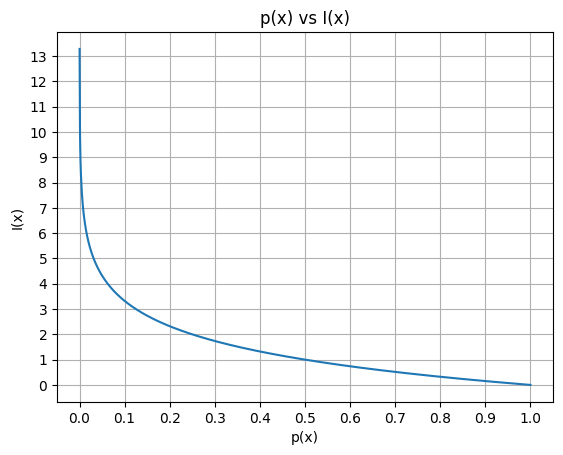

In [8]:
import matplotlib.pyplot as plt


def self_information(p):
    return -np.log2(p)


ps = np.linspace(0.0001, 1, 1000)

fig, ax = plt.subplots()
ax.plot(ps, self_information(ps))
ax.set_title("p(x) vs I(x)")
ax.set_xlabel("p(x)")
ax.set_ylabel("I(x)")
ax.set_xticks(np.arange(0, 1.05, 0.1))
ax.set_yticks(np.arange(0, 14, 1))
ax.grid()

Notice that when an event always happens (probability of 1) the self-information is zero, i.e. $I(x) = 0$ when $p(x) = 1$, whereas an event with a probability of near zero has a self-information value approaching infinity, i.e. as $p(x) \rightarrow 0$ then $I(x) \rightarrow \infty$.

**Entropy**

Entropy is a function which assigns a single real valued number to a finite discrete distribution. It is the expected value of the self-information of a random variable.

The entropy of $X$ is defined as:

$$H(X) = \mathbb{E}_{X \sim p}[I(X)] = -\sum_x p(x)\log_2p(x)$$

The entropy is the expected amount of information contained in a random variable, $X$.

We implement this below, using some hacks to get around the case when $p(x) = 0$ (as Python will try to calculate $\log_2p(x) = -\infty$) by simply setting that $p(x)\log_2p(x)$ to zero manually when $p(x)=0$.

In [20]:
def entropy(p):
    return np.sum([self_information(px) * px if px != 0 else 0 for px in p])


p = [0.4, 0.3, 0.2, 0.05, 0.05]

print(entropy(p))

1.9464393446710153


Another way of thinking of entropy is the amount of randomness within a random variable. The more randomness, the higher the entropy.

If one outcome is a lot more likely than the others, there is less randomness in the random variable as you are more likely to get that highly probable outcome.

In [21]:
p = [0.99, 0.0025, 0.0025, 0.0025, 0.0025]

print(entropy(p))

0.10079313589591118


As an extreme, if one value has 100% probability, whilst the rest have 0%, then you have 0 entropy. There is no randomness in the system in the same way that there is no information given by an event a with probability of 1.

Formally, if $X$ can only take one value, $x_0$, then: 

$$H(X) = \mathbb{E}_{X \sim p}[I(X)] = \mathbb{E}_{X \sim p}[I(x_0)] = I(x_0) = -\log_2p(x_0) = -\log_21 = 0$$

In [22]:
p = [1, 0, 0, 0, 0]

print(entropy(p))

0.0


Entropy is at a maximum when randomness is maximized, when all values are equally likely.

In [23]:
p = [0.2, 0.2, 0.2, 0.2, 0.2]

print(entropy(p))

2.321928094887362


**Codes**

Consider the scenario where we have a random variable $X$ with distribution $p$. We get samples from $X$ and send those through a channel.

To send the samples, we must encode them in some way. We define a *code*, i.e. a function $C:X\rightarrow \Sigma^*$, that maps values $x$ to *words* in alphabet $\Sigma$.

$\Sigma$ is the set of symbols in the alphabet, whereas $\Sigma^*$ is the set of all possible words.

For example, if we want to encode samples into binary strings, then $\Sigma = \{0, 1\}$ and $\Sigma^* = \{0, 1\}^* = \{0, 1, 00, 01, 10, 11, 000, \cdots\}$

One possible encoding using $\Sigma = \{0, 1\}$ is simply representing the integer values by their binary string equivalents:

$$C(0) = \texttt{0}, \; C(1) = \texttt{1}, \; C(2) = \texttt{10}, \; C(3) = \texttt{11}, \; C(4) = \texttt{100}$$

In [24]:
def C(x):
    return format(x, "b")


X = [0, 1, 2, 3, 4]

CX = [C(x) for x in X]

print(CX)

['0', '1', '10', '11', '100']


The *extension* of $C$ is defined by:

$$C^*(x_1,x_2,\cdots, x_n)=C(x_1)C(x_2)\cdots C(x_n)$$

This implies that when we send our samples, we just concatenate them into one long string.

$$C^*(0, 1, 2) = C(0)C(1)C(2) = \texttt{0110}$$

We can say $C^*$ is *injective* if $C$ is *uniquely decodable*. That is, there is only one possible sequence of samples which result in an encoded string. 

The above binary encoding is **not** injective, as if you received a binary message of $\texttt{10}$ you wouldn't know if this was supposed to be two values $1$ and $0$ sent down the channel or a single value $2$ as $C^*(1,0) = \texttt{10} = C^*(2)$

One method of calculating an injective code for a discrete random variable $X$ with distribution $p$ is Huffman coding. (I won't fully explain Huffman coding in detail here, but [this](https://www.youtube.com/watch?v=B3y0RsVCyrw) is a good video on it.) Below is a function to calculate the Huffman coding for a given probability distribution and set of symbols:

In [25]:
def huffman(p):
    """Return a Huffman code for an ensemble with distribution p."""

    # Base case of only two symbols, assign 0 or 1 arbitrarily
    if len(p) == 2:
        return dict(zip(p.keys(), ["0", "1"]))

    # Create a new distribution by merging lowest prob. pair
    p_prime = p.copy()
    a1, a2 = lowest_prob_pair(p)
    p1, p2 = p_prime.pop(a1), p_prime.pop(a2)
    p_prime[a1 + a2] = p1 + p2

    # Recurse and construct code on new distribution
    c = huffman(p_prime)
    ca1a2 = c.pop(a1 + a2)
    c[a1], c[a2] = ca1a2 + "0", ca1a2 + "1"

    return c


def lowest_prob_pair(p):
    """Return pair of symbols from distribution p with lowest probabilities."""
    assert len(p) >= 2  # Ensure there are at least 2 symbols in the dict.
    sorted_p = [(k, p[k]) for k in sorted(p, key=p.get, reverse=False)]
    return sorted_p[0][0], sorted_p[1][0]

If we had three symbols ("a", "b", and "c") with probabilities (0.5, 0.25, and 0.25, respectively) then the Huffman coding is:

In [30]:
X = {"a": 0.5, "b": 0.25, "c": 0.25}

code = huffman(X)

code

{'a': '0', 'b': '10', 'c': '11'}

We can re-use the symbols/probabilities we've been using previously, where the symbols are just the outcome values. Notice how the Huffman coding for symbols with lower probability is longer than those with higher probability. This is intentional as for efficient communication, symbols sent more often should use less bits.

In [31]:
X = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.05, 4: 0.05}  # value: probability

code = huffman(X)

code

{0: '0', 1: '10', 2: '111', 3: '1100', 4: '1101'}

We can now have a function which translates symbols using a given code:

In [28]:
def C(x, code):
    assert x in code.keys()
    return code[x]

**Shannon's Source Coding Theorem**

Let $X$ be a discrete random variable and $C : X \rightarrow \Sigma^*$ a uniquely decodable code. If $C$ is **optimal**, i.e. it minimizes $\mathbb{E}_X[\text{length}(C(X))]$ (where $\text{length}$ gives the number of bits in the encoded symbol, e.g. if $C(2) = \texttt{111}$ then $\text{length}(C(2))=\text{length}(\texttt{111})=3$), then Shannon's source coding theorem states:

$$\frac{H(X)}{\log_2|\Sigma|} \leq \mathbb{E}_X[\text{length}(C(X))] \lt \frac{H(X)}{\log_2|\Sigma|} + 1$$

In our case, where we are encoding the values as binary strings, where the alphabets have two characters, 0 and 1, we get $\log_2|\Sigma|=\log_2(2)=1$. Thus, the above can be simplified to:

$$H(X) \leq \mathbb{E}_X[\text{length}(C(X))] \lt H(X) + 1$$

Lets check this using our $X$ and $p$:

In [29]:
X = [0, 1, 2, 3, 4]
length_CX = [len(C(x, code)) for x in X]
p = [0.4, 0.3, 0.2, 0.05, 0.05]

print(f"             H(X) = {entropy(p)}")
print(f"E_x[length(C(X))] = {expectation(length_CX, p)}")
print(f"        H(X) + 1  = {entropy(p) + 1}")

             H(X) = 1.9464393446710153
E_x[length(C(X))] = 2.0
        H(X) + 1  = 2.946439344671015


Shannon's source coding theorem shows us that when using a binary string we can never get an expected length less than $H(X)$. However, an optimal code will never have a length greater than $H(X)+1$

So where does the $+1$ come from? Let's find out! First, remembering that entropy, $H(X)$ is equal to the expected self-information, $\mathbb{E}_X[I(X)]$

$$\mathbb{E}_X[I(X)] \leq \mathbb{E}_X[\text{length}(C(X))] \lt \mathbb{E}_X[I(X)] + 1$$

Thus, $I(X)$ has something to do with $\text{length}(C(X))$: symbols that occur more frequently (higher $p(x)$ and thus lower $I(x)$) are assigned shorter codes, while rarer symbols (lower $p(x)$, higher $I(x)$)) receive longer codes.

In theory, if we could assign each value in $X$ to a binary string with length equal to their self-information, $I(X)$, then the expected length of the strings would be $H(X)$, i.e. $H(X) = \mathbb{E}_X[\text{length}(C(X))] = \mathbb{E}_X[\text{I(X)}]$. However, $I(X)$ is not always an integer and it is not possible to send a fraction of a string through a channel, so the length needs to be the nearest whole number that is not less than $I(X)$, which we will denote $I_b(X)$. Thus:

$$I(X) \leq I_b(X) \lt I(X) + 1$$

Taking the expectation of each:

$$\mathbb{E}_X[I(X)] \leq \mathbb{E}_X[I_b(X)] \lt \mathbb{E}_X[I(X)+1] = \mathbb{E}_X[I(X)]+1$$

Using $\mathbb{E}_X[I(X)] = H(X)$ and $\mathbb{E}_X[I_b(X)] = \mathbb{E}_X[\text{length}(C(X))]$ when $C$ is optimal, which we assume it is, then we get:

$$H(X) \leq \mathbb{E}_X[\text{length}(C(X))] \lt H(X) + 1$$

This is the Shannon source coding theorem! It shows that binary data can never be compressed to have an expected symbol length below its entropy value.

**Cross Entropy**

The cross entropy of two distributions $p$ and $q$ of a variable $X$ is defined as:

$$H(p, q) = \mathbb{E}_{X \sim p}[I_q(X)] = - \sum_xp(x)\log_2q(x)$$

What is the meaning of cross entropy? $I_q(X)$ is the self-information of $x$, assuming that $X \sim q$, so why take the expected value with respect to $p$ instead of $q$?

If we think about it in terms of codes, we can say $C_q : X \rightarrow \{0, 1\}^*$ is an optimal code for $X$, assuming that $X \sim q$, thus $\text{length}(C_q(x)) \approx I_q(x)$. We can now re-write cross entropy as:

$$H(p, q) = \mathbb{E}_{X \sim p}[\text{length}(C_q(X))]$$

This is the number of bits required, on average, to transmit a sample $x$ from $X \sim p$ using a code optimized for $X \sim q$.

$$H(p) = H(p, p) \leq H(p, q)$$

where $H(p)$ is the entropy of $X$ using distribution $p$.

In machine learning, we commonly use cross entropy loss. Using this loss function, we have $p$ as the true target distribution (usually represented by a one-hot encoded vector), with $q$ as the model's output distribution (usually the output of a softmax activation function). As $q$ gets closer to $p$, the cross entropy value (our loss) decreases with a minimum of $H(p)$ that equals 0. This is because the entropy of a one-hot encoded vector is zero as it only has a single value with a probability of 1 and the rest have a probability of 0.

We implement this below, avoiding the case when $q(x) = 0$ (and thus $\log_2q(x) = -\infty$) by simply setting $q(x) = \epsilon$, where $\epsilon$ is just a very small number and thus $\log_2\epsilon$ is a very large negative number.

In [37]:
def cross_entropy(p, q, eps=1e-10):
    return -np.sum(
        [px * np.log2(qx) if qx != 0 else px * np.log2(eps) for (px, qx) in zip(p, q)]
    )


p = [0, 1]

q_1 = [1, 0]
q_2 = [0.7, 0.3]
q_3 = [0.5, 0.5]
q_4 = [0.3, 0.7]
q_5 = [0, 1]

print(f"H(p) = {entropy(p)}")
print(f"H(p, p) = {cross_entropy(p, p)}")
print(f"H(p, q_1) = {cross_entropy(p, q_1)}")
print(f"H(p, q_2) = {cross_entropy(p, q_2)}")
print(f"H(p, q_3) = {cross_entropy(p, q_3)}")
print(f"H(p, q_4) = {cross_entropy(p, q_4)}")
print(f"H(p, q_5) = {cross_entropy(p, q_5)}")

H(p) = 0.0
H(p, p) = -0.0
H(p, q_1) = 33.219280948873624
H(p, q_2) = 1.7369655941662063
H(p, q_3) = 1.0
H(p, q_4) = 0.5145731728297583
H(p, q_5) = -0.0


**Kullback-Leibler Divergence**

The Kullack-Leibler (KL) divergence is used to measure the "distance" (or similarity) between two distributions. However, it's not a real distance, like the distance between two 2D points, and it is not symmetric, i.e. $D_{KL}(p||q) \neq D_{KL}(q||p)$.

The KL divergence between two distributions $p$ and $q$ of a variable $X$ is defined by:

$$D_{KL}(p||q) = \sum_x p(x) \log_2\frac{p(x)}{q(x)}$$

KL divergence has the properties that $D_{KL}(p||q) \ge 0$ and $D_{KL}(p||q) = 0$ only when $p = q$.

KL divergence is used in machine learning (in variational autoencoders and generative adversarial networks) to find a probability distribution you don't know and don't control $p$, using a probability distribution that you do know and control, $q$. As $q$ gets closer to $p$, the KL divergence decreases to a minimum of zero when $p = q$.

We'll implement this below. To avoid doing $\log_2(0)$ when $p(x) = 0$, we simply replace $p(x)\log_2(\frac{p(x)}{q(x)})$ with 0. To avoid doing division by 0 in the logarithm when $q(x) = 0$, we replace $q(x)$ with $\epsilon$ when $q(x) = 0$.

In [38]:
def kl_div(p, q, eps=1e-10):
    return np.sum(
        [
            px * np.log2(px / (qx if qx != 0 else eps)) if px != 0 else 0
            for (px, qx) in zip(p, q)
        ]
    )


p = [0, 1]

q_1 = [1, 0]
q_2 = [0.7, 0.3]
q_3 = [0.5, 0.5]
q_4 = [0.3, 0.7]
q_5 = [0, 1]

print(f"D_KL(p || q_1) = {kl_div(p, q_1)}")
print(f"D_KL(p || q_2) = {kl_div(p, q_2)}")
print(f"D_KL(p || q_3) = {kl_div(p, q_3)}")
print(f"D_KL(p || q_4) = {kl_div(p, q_4)}")
print(f"D_KL(p || q_5) = {kl_div(p, q_5)}")
print(f"D_KL(q_3 || p) = {kl_div(q_3, p)}")

D_KL(p || q_1) = 33.219280948873624
D_KL(p || q_2) = 1.7369655941662063
D_KL(p || q_3) = 1.0
D_KL(p || q_4) = 0.5145731728297582
D_KL(p || q_5) = 0.0
D_KL(q_3 || p) = 15.609640474436812


We can re-arrange the KL divergence equation to get:
    
$$\begin{align*}
D_{KL}(p||q) &= \sum_x p(x) \log_2\frac{p(x)}{q(x)}\\ 
         &= \mathbb{E}_{X \sim p}[\log_2\frac{p(X)}{q(X)}]\\
         &= \mathbb{E}_{X \sim p}[\log_2p(X) - \log_2q(X)]\\
         &= \mathbb{E}_{X \sim p}[I_q(X) - I_p(X)]\\
         &= \mathbb{E}_{X \sim p}[I_q(X)] - \mathbb{E}_{X \sim p}[I_p(X)]\\
         &= H(p, q) - H(p, p)\\
         &= H(p, q) - H(p)
\end{align*}$$

The final expression tells us that the KL divergence is the number of bits wasted when we transmit samples from $X \sim p$ by using a code optimized for $ X \sim q$.

In machine learning, $p$ will usually be a one-hot vector, which means $H(p) = 0$. Thus, KL divergence will be equal to the cross entropy!

Note that below we use `np.isclose` instead of `==` as we get small rounding errors doing the calculations.

In [39]:
p = [0, 1]

q_1 = [1, 0]
q_2 = [0.7, 0.3]
q_3 = [0.5, 0.5]
q_4 = [0.3, 0.7]
q_5 = [0, 1]


print(
    f"D_KL(p || q_1) = H(p, q_1) - H(p)? {np.isclose(kl_div(p, q_1), cross_entropy(p, q_1) - entropy(p))}"
)
print(
    f"D_KL(p || q_2) = H(p, q_2) - H(p)? {np.isclose(kl_div(p, q_2), cross_entropy(p, q_2) - entropy(p))}"
)
print(
    f"D_KL(p || q_3) = H(p, q_3) - H(p)? {np.isclose(kl_div(p, q_3), cross_entropy(p, q_3) - entropy(p))}"
)
print(
    f"D_KL(p || q_4) = H(p, q_4) - H(p)? {np.isclose(kl_div(p, q_4), cross_entropy(p, q_4) - entropy(p))}"
)
print(
    f"D_KL(p || q_5) = H(p, q_5) - H(p)? {np.isclose(kl_div(p, q_5), cross_entropy(p, q_5) - entropy(p))}"
)

D_KL(p || q_1) = H(p, q_1) - H(p)? True
D_KL(p || q_2) = H(p, q_2) - H(p)? True
D_KL(p || q_3) = H(p, q_3) - H(p)? True
D_KL(p || q_4) = H(p, q_4) - H(p)? True
D_KL(p || q_5) = H(p, q_5) - H(p)? True


**Jensen-Shannon Divergence**

The Jensen-Shannon (JS) divergence is another metric used to measure the difference between two probability distributions. It is given by:

$$D_{JS}(p||q) = \frac{1}{2}D_{KL}(p||m)+\frac{1}{2}D_{KL}(q||m)$$

$m$ is the elementwise average of the two distributions, $m = (p+q)/2$.

The JS divergence has three nice properties. First, $D_{JS}$ is bound between 0 and 1, i.e. $[0, 1]$. Second, $D_{JS}$ is symmetric, i.e. $D_{JS}(p||q) = D_{JS}(q||p)$. Finally, the $D_{JS}$ term is a lot smoother as $q$ approaches $p$, this is useful when it is used as a loss function as we get smoother gradients. 

First, let's check the bounds and the symmetry.

In [40]:
def js_div(p, q):
    m = [(px + qx) / 2 for (px, qx) in zip(p, q)]
    return (kl_div(p, m) + kl_div(q, m)) * 0.5


p = [0, 1]

q_1 = [1, 0]
q_2 = [0.7, 0.3]
q_3 = [0.5, 0.5]
q_4 = [0.3, 0.7]
q_5 = [0, 1]

print(
    f"D_JS(p || q_1) = {js_div(p, q_1)} = D_JS(q_1 || p)? {np.isclose(js_div(p, q_1), js_div(q_1, p))}"
)
print(
    f"D_JS(p || q_2) = {js_div(p, q_2)} = D_JS(q_2 || p)? {np.isclose(js_div(p, q_2), js_div(q_2, p))}"
)
print(
    f"D_JS(p || q_3) = {js_div(p, q_3)} = D_JS(q_3 || p)? {np.isclose(js_div(p, q_3), js_div(q_3, p))}"
)
print(
    f"D_JS(p || q_4) = {js_div(p, q_4)} = D_JS(q_4 || p)? {np.isclose(js_div(p, q_4), js_div(q_4, p))}"
)
print(
    f"D_JS(p || q_5) = {js_div(p, q_5)} = D_JS(q_5 || p)? {np.isclose(js_div(p, q_5), js_div(q_5, p))}"
)

D_JS(p || q_1) = 1.0 = D_JS(q_1 || p)? True
D_JS(p || q_2) = 0.49342260576014463 = D_JS(q_2 || p)? True
D_JS(p || q_3) = 0.31127812445913283 = D_JS(q_3 || p)? True
D_JS(p || q_4) = 0.16919485510105411 = D_JS(q_4 || p)? True
D_JS(p || q_5) = 0.0 = D_JS(q_5 || p)? True


Now, let's check how smooth it is by slowly changing our target distribution, $q$ to match the true distribution, $p$.

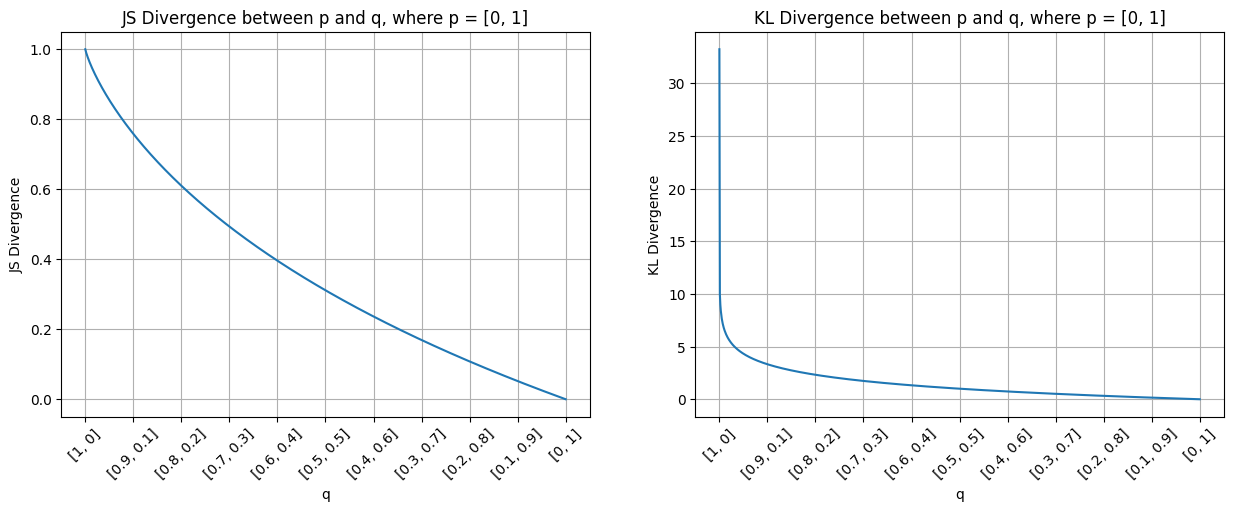

In [45]:
ps = [[0, 1] for _ in range(1000)]
qs = [[1 - q, q] for q in np.linspace(0, 1, 1000)]
qs_one = [q[1] for q in qs]

ticks = [
    (1, 0),
    (0.9, 0.1),
    (0.8, 0.2),
    (0.7, 0.3),
    (0.6, 0.4),
    (0.5, 0.5),
    (0.4, 0.6),
    (0.3, 0.7),
    (0.2, 0.8),
    (0.1, 0.9),
    (0, 1),
]

js_divs = [js_div(p, q) for (p, q) in zip(ps, qs)]
kl_divs = [kl_div(p, q) for (p, q) in zip(ps, qs)]

fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
ax1, ax2 = ax
ax1.set_xticks(
    [x for (_, x) in ticks], [f"[{t0}, {t1}]" for (t0, t1) in ticks], rotation=45
)
ax1.set_title("JS Divergence between p and q, where p = [0, 1]")
ax1.set_ylabel("JS Divergence")
ax1.set_xlabel("q")
ax1.grid()
ax1.plot(qs_one, js_divs)
ax2.set_xticks(
    [x for (_, x) in ticks], [f"[{t0}, {t1}]" for (t0, t1) in ticks], rotation=45
)
ax2.set_title("KL Divergence between p and q, where p = [0, 1]")
ax2.set_ylabel("KL Divergence")
ax2.set_xlabel("q")
ax2.grid()
ax2.plot(qs_one, kl_divs)

**Wassterstein Metric / Earth Mover's Distance**

The Wasserstein metric is yet another metric used to measure the difference between two distributions. It is also referred to as the *Earth Mover's distance* or EMD. $EMD = 0$ when $p = q$. It is symmetric, and is always $\ge 0$.

We calculate EMD as:

$$EMD = \sum_x |\delta_x|$$

Where:

$$\delta_0 = 0\text{ and } \delta_{i+1} = \delta_{i} + p(x) - q(x)$$ 

You can think of EMD as the amount of *work* done to make the two probability distributions equal. We calculate the work by finding the amount of probability distribution to be moved, multiplied by the distance it has to move.

For example, let's say we have $p = [0.15, 0.2, 0.65]$ and $q = [0.35, 0.2, 0.45]$. To make these two equal, we need to move $0.2$ from $q_1$ to $q_3$. Thus, the amount is $0.2$, the distance is $2$, and thus $EMD = 0.2 * 2 = 0.4$, explicitly:

$$\begin{align*}
\delta_0 &= 0 \\
\delta_1 &= 0 + 0.15 - 0.35 =-0.2 \\
\delta_2 &= -0.2 + 0.2 - 0.2 =-0.2 \\
\delta_3 &= -0.2 + 0.65 - 0.45 = 0 
\end{align*}
$$

$$EMD = |\delta_0| + |\delta_1| + |\delta_2| + |\delta_3| = |0|+|-0.2|+|-0.2|+|0| = 0.4$$

In [50]:
def emd(p, q):
    return np.sum(np.abs(np.cumsum(np.subtract(p, q))))

In [51]:
p = [0.15, 0.2, 0.65]
q = [0.35, 0.2, 0.45]

print(emd(p, q))

0.4


Why would we use the EM distance over the JS divergence? Let's look at an example:

In [52]:
p = [0, 0, 0, 1]

q_1 = [1, 0, 0, 0]
q_2 = [0, 1, 0, 0]
q_3 = [0, 0, 1, 0]
q_4 = [0, 0, 0, 1]

print(f"p = {p}\n")

print(f"q = {q_1}, EMD = {emd(p, q_1)}, D_JS = {js_div(p, q_1)}")
print(f"q = {q_2}, EMD = {emd(p, q_2)}, D_JS = {js_div(p, q_2)}")
print(f"q = {q_3}, EMD = {emd(p, q_3)}, D_JS = {js_div(p, q_3)}")
print(f"q = {q_4}, EMD = {emd(p, q_4)}, D_JS = {js_div(p, q_4)}")

p = [0, 0, 0, 1]

q = [1, 0, 0, 0], EMD = 3, D_JS = 1.0
q = [0, 1, 0, 0], EMD = 2, D_JS = 1.0
q = [0, 0, 1, 0], EMD = 1, D_JS = 1.0
q = [0, 0, 0, 1], EMD = 0, D_JS = 0.0


As the probability mass changes, the JS divergence remains $1$ for each distribution where $p \neq q$. However, the EM distance does take the probability mass into account, and reduces as the probability mass of $q$ gets closer to that of $p$.

Let's look at a plot between EMD and JS divergence.

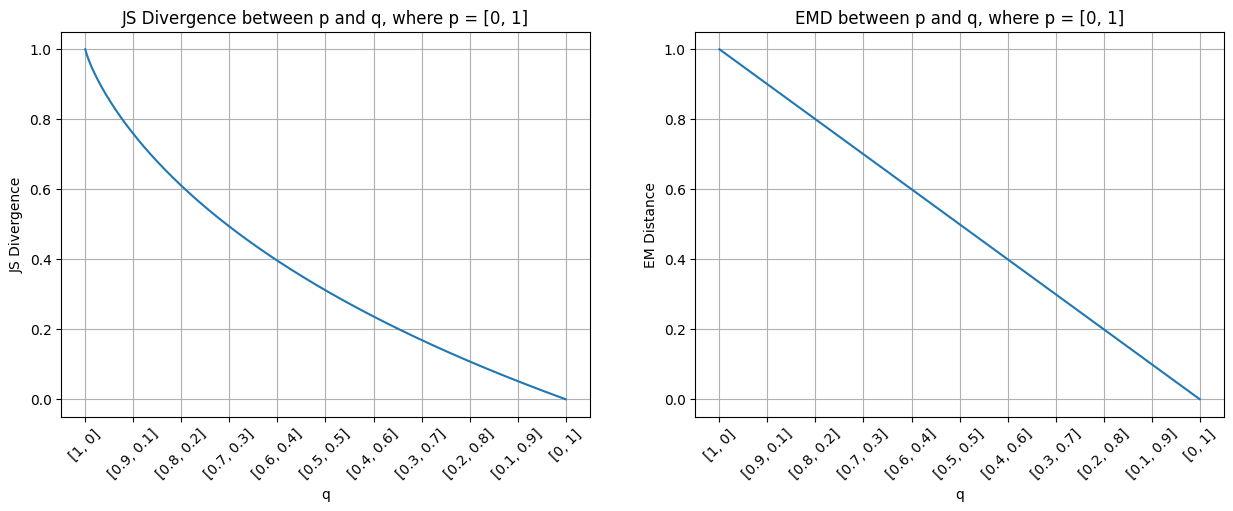

In [55]:
ps = [[0, 1] for _ in range(1000)]
qs = [[1 - q, q] for q in np.linspace(0, 1, 1000)]
qs_one = [q[1] for q in qs]

ticks = [
    (1, 0),
    (0.9, 0.1),
    (0.8, 0.2),
    (0.7, 0.3),
    (0.6, 0.4),
    (0.5, 0.5),
    (0.4, 0.6),
    (0.3, 0.7),
    (0.2, 0.8),
    (0.1, 0.9),
    (0, 1),
]

js_divs = [js_div(p, q) for (p, q) in zip(ps, qs)]
emds = [emd(p, q) for (p, q) in zip(ps, qs)]

fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
ax1, ax2 = ax
ax1.set_xticks(
    [x for (_, x) in ticks], [f"[{t0}, {t1}]" for (t0, t1) in ticks], rotation=45
)
ax1.set_title("JS Divergence between p and q, where p = [0, 1]")
ax1.set_ylabel("JS Divergence")
ax1.set_xlabel("q")
ax1.grid()
ax1.plot(qs_one, js_divs)
ax2.set_xticks(
    [x for (_, x) in ticks], [f"[{t0}, {t1}]" for (t0, t1) in ticks], rotation=45
)
ax2.set_title("EMD between p and q, where p = [0, 1]")
ax2.set_ylabel("EM Distance")
ax2.set_xlabel("q")
ax2.grid()
ax2.plot(qs_one, emds)

We can also see that EMD is linear, giving us well behaved gradients just like the JS divergence.

And that's it! Hopefully this crash course on information theory will be enough for you to understand enough from a machine learning perspective.